In [5]:
# set up imports
import pandas as pd, numpy as np, seaborn as sns
from tabulate import tabulate
import statsmodels
import arch
import matplotlib
matplotlib.use('qt5agg')

# configure plot style
import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams["figure.figsize"] = (7,2.75)
plt.rcParams['figure.constrained_layout.use'] = False
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['lines.linewidth'] = 0.8
save_plot_to =  r'C:\\Users\joche\OneDrive\03 TUM - TUM-BWL\Semester 8\01 Bachelorarbeit\04 Results\Plots/'

In [6]:
# load data from excel file
mydateparser = lambda x: pd.datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S')
btc = pd.read_excel('Data/BTC_closing.xlsx',squeeze=True, parse_dates=[0], index_col=0, date_parser=mydateparser)

# crop data: 2015-08-07 to 2020-06-26
start_date = '2015-08-07'
end_date = '2020-06-26'
btc = btc[start_date : end_date]

In [7]:
# Plot btc neben btc_returns
#btc_log = np.log(btc)
btc_returns = btc.pct_change().mul(100)
fig_1, axes = plt.subplots(1,2, sharex=True)
axes[0].plot(btc, color='black')
axes[0].set_title('btc')
axes[1].plot(btc_returns[1:])
axes[1].set_title('btc_returns')

Text(0.5, 1.0, 'btc_returns')

In [ ]:
# OPTIONAL ++

# convert btc_returns back into btc: Later for prediction
ret = btc.pct_change().mul(100)
btc_rev = ((1 + ret.mul(0.01).shift(-1)) * btc).shift(1)
print(btc)
print(btc_rev)

# OPTIONAL ++

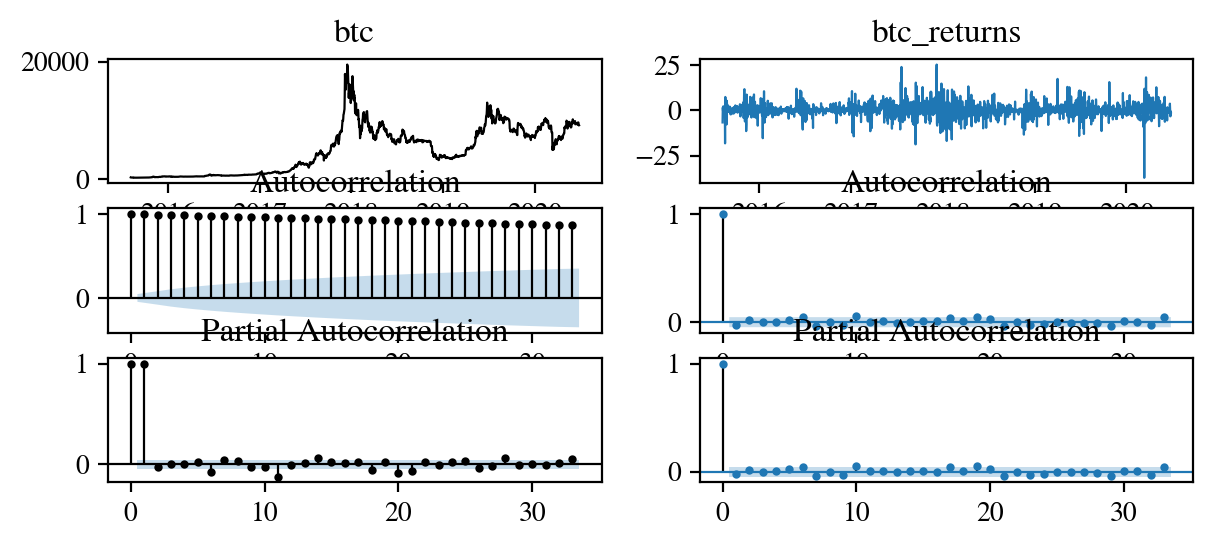

In [8]:
# Plot btc neben btc_returns, jeweils mit ACF und PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig_2, axs = plt.subplots(3,2)
axs[0][0].plot(btc, color='black')
axs[0][0].set_title('btc')
axs[0][1].plot(btc_returns)
axs[0][1].set_title('btc_returns')
plot_acf(btc, color='black', ax=axs[1][0], markersize=2)
plot_acf(btc_returns[1:], ax=axs[1][1], markersize=2)
plot_pacf(btc, color='black', ax=axs[2][0], markersize=2)
plot_pacf(btc_returns[1:], ax=axs[2][1], markersize=2)

In [9]:
# ADF- and PP- mit btc
from arch.unitroot import ADF, PhillipsPerron
adf = ADF(btc)
pp = PhillipsPerron(btc)
print(adf.summary().as_latex(),'\n\n\n', pp.summary().as_latex())

\begin{center}
\begin{tabular}{lr}
\toprule
Test Statistic     &             -1.972  \\
P-value            &              0.299  \\
\bottomrule
\end{tabular}
%\caption{Augmented Dickey-Fuller Results}
\end{center}

Trend: Constant \newline
 Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%) \newline
 Null Hypothesis: The process contains a unit root. \newline
 Alternative Hypothesis: The process is weakly stationary. 


 \begin{center}
\begin{tabular}{lr}
\toprule
Test Statistic     &             -1.771  \\
P-value            &              0.395  \\
\bottomrule
\end{tabular}
%\caption{Phillips-Perron Test (Z-tau)}
\end{center}

Trend: Constant \newline
 Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%) \newline
 Null Hypothesis: The process contains a unit root. \newline
 Alternative Hypothesis: The process is weakly stationary.


In [10]:
# ADF- and PP- mit btc_returns
from arch.unitroot import ADF, PhillipsPerron
adf = ADF(btc_returns[1:])
pp = PhillipsPerron(btc_returns[1:])
print(adf.summary().as_latex(),'\n\n\n', pp.summary().as_latex())

\begin{center}
\begin{tabular}{lr}
\toprule
Test Statistic     &            -43.245  \\
P-value            &              0.000  \\
\bottomrule
\end{tabular}
%\caption{Augmented Dickey-Fuller Results}
\end{center}

Trend: Constant \newline
 Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%) \newline
 Null Hypothesis: The process contains a unit root. \newline
 Alternative Hypothesis: The process is weakly stationary. 


 \begin{center}
\begin{tabular}{lr}
\toprule
Test Statistic     &            -43.342  \\
P-value            &              0.000  \\
\bottomrule
\end{tabular}
%\caption{Phillips-Perron Test (Z-tau)}
\end{center}

Trend: Constant \newline
 Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%) \newline
 Null Hypothesis: The process contains a unit root. \newline
 Alternative Hypothesis: The process is weakly stationary.


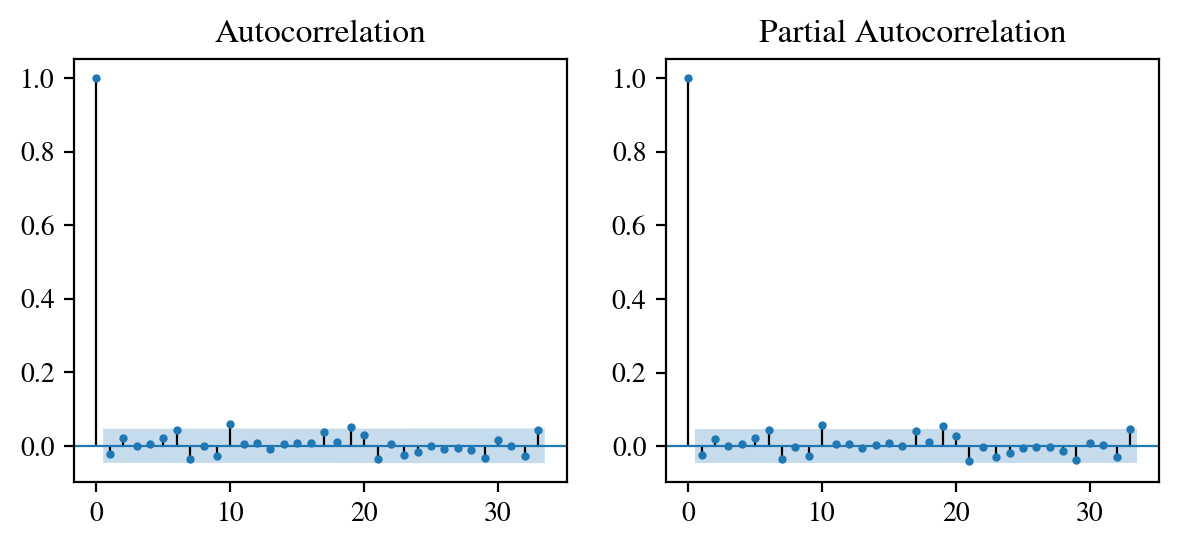

In [11]:
# ACF und PACF plot für btc_returns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig_3, axes = plt.subplots(1,2)
plot_acf(btc_returns[1:], ax=axes[0], markersize=2)
plot_pacf(btc_returns[1:], ax=axes[1], markersize=2)

In [45]:
# fit ARIMA(p,0,q) model to (stationary) returns
import pmdarima as pm
import warnings
warnings.filterwarnings('ignore')
model = pm.ARIMA(order = (1,0,1))
model_fitted = model.fit(btc_returns[1:])
model_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1785
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -4998.117
Date:                Sun, 30 Aug 2020   AIC                          10004.233
Time:                        12:16:04   BIC                          10026.182
Sample:                             0   HQIC                         10012.339
                               - 1785                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5248      0.179      2.926      0.003       0.173       0.876
ar.L1         -0.9011      0.105     -8.585      0.000      -1.107      -0.695
ma.L1          0.8822      0.113      7.840      0.000       0.662       1.103
sigma2        15.8354      0.232     68.364      0.000      15.381      16.289
===================================================================================
Ljung-Box (Q):                       38.35   Jarque-Bera (JB):              5487.52
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               1.72   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
# save current model summary as LaTeX to .txt file
with open(save_plot_to+'SARIMAX_logs_LaTeX.txt', 'a') as myfile:
    myfile.write(model_fitted.summary().as_latex()+'\n\n')

In [47]:
# fit ARIMA(p,0,q) model with auto_arima to (stationary) returns - double check
import pmdarima as pm
import warnings
warnings.filterwarnings('ignore')

model_auto = pm.auto_arima(btc_returns[1:], start_p=0, start_q=0, max_p=11, max_q=11,
                      test='adf',
                      m=1,
                      d=None,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      seasonal=False,
                      stepwise=True)

print(model_auto.summary())

Performing stepwise search to minimize aic
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=10003.599, BIC=10014.574, Time=0.059 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=10004.627, BIC=10021.088, Time=0.152 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=10004.663, BIC=10021.125, Time=0.238 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=10010.149, BIC=10015.636, Time=0.030 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=10004.233, BIC=10026.182, Time=0.954 seconds
Total fit time: 1.455 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1785
Model:                        SARIMAX   Log Likelihood               -4999.800
Date:                Sun, 30 Aug 2020   AIC                          10003.599
Time:                        12:25:12   BIC                          10014.574
Sample:                             0   HQIC                 

In [48]:
# save current model_auto summary as LaTeX to .txt file
with open(save_plot_to+'SARIMAX_logs_LaTeX.txt', 'a') as myfile:
    myfile.write(model_auto.summary().as_latex()+'\n\n')

In [12]:
# Teile btc in 80% train und 20% test
train_size = int(len(btc) * 0.8)
btc_train, btc_test = btc[:train_size], btc[train_size:]
print('btc_train:\t', len(btc_train), '\nbtc_test:\t', len(btc_test), '\nSUM:\t\t',
      len(btc_train) + len(btc_test), '\nlen(btc):\t', len(btc))

# Teile btc_returns in 80% train und 20% test
train_size = int(len(btc_returns[1:]) * 0.8)
btc_returns_train, btc_returns_test = btc_returns[:train_size], btc_returns[train_size:]
print('btc_returns_train:\t', len(btc_returns_train), '\nbtc_returns_test:\t', len(btc_returns_test),
      '\nSUM:\t\t\t', len(btc_returns_train) + len(btc_returns_test), '\nlen(btc_returns):\t', len(btc_returns))

btc_train:	 1428 
btc_test:	 358 
SUM:		 1786 
len(btc):	 1786
btc_returns_train:	 1428 
btc_returns_test:	 358 
SUM:			 1786 
len(btc_returns):	 1786


In [30]:
# Einschrittprognose für btc mit ARIMA(0,0,0)
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error as mse
import pmdarima as pm

history_ret = [x for x in btc_returns[1:]]
pred_val_btc = list()
lo_conf_int_btc = list()
up_conf_int_btc = list()

def einschritt_prognose_btc():
    ausreisser_ctr = 0
    for i in range(len(btc_test)):
        model = pm.ARIMA(order=(0,0,0))
        model_fitted = model.fit(y=history_ret, disp=False)
        model_result = model_fitted.predict(n_periods=1, return_conf_int=True)
        yhat_btc = (model_result[0][0]*0.01 + 1) * btc[1427 + i]
        lo_conf_val_btc = (model_result[1][0][0]*0.01 + 1) * btc[1427 + i]
        up_conf_val_btc = (model_result[1][0][1]*0.01 + 1) * btc[1427 + i]
        if btc[1427 + i] > up_conf_val_btc or btc[1427 + i] < lo_conf_val_btc:
            ausreisser_ctr += 1
        pred_val_btc.append(yhat_btc)
        lo_conf_int_btc.append(lo_conf_val_btc)
        up_conf_int_btc.append(up_conf_val_btc)
        history_ret.append(btc_returns_test[i])

    # return mse_btc and ausreisser_ctr
    return (np.sqrt(mse(pred_val_btc, btc_test.values)), ausreisser_ctr,
            pred_val_btc, lo_conf_int_btc, up_conf_int_btc)
    
pred_result_btc = einschritt_prognose_btc()
print(pred_result_btc)

(340.30759233072064, 0, [11246.39453616822, 11008.613623562615, 11239.449821351202, 11482.538584602236, 12320.441473477744, 12609.24420920092, 12190.523824004167, 11390.007702732812, 11848.846991393575, 11423.813730401376, 10283.772738780093, 10924.89103687294, 9502.863333275161, 9719.707226980208, 10695.565853246719, 10559.355273826908, 10796.525859844385, 10627.9294254625, 10371.07919641256, 9927.293493893188, 9838.15215773907, 9938.37038206889, 9896.681682124945, 9502.789743457892, 9578.196819974171, 9544.36490432046, 9632.903859967771, 10112.644605981255, 10427.689014464775, 10546.558727330279, 10851.094026200966, 11000.013310683049, 11838.232520278816, 11509.656144948274, 11974.97567901484, 11999.478511184005, 11895.648245937778, 11385.040544202982, 11555.140932677308, 11413.701442706986, 10925.310581693257, 10078.455276328483, 10339.127817821582, 10402.105127080662, 10259.031616583548, 10373.453829578546, 10945.530173519612, 10792.199348035696, 10165.000524724994, 10157.973449307

In [31]:
# make series for plotting predicted vs. actual btc
index_pred = np.arange(len(btc_train) + 1, len(btc) + 1)
pred_val_btc_series = pd.Series(pred_result_btc[2], index=index_pred)
test_series_btc = pd.Series(btc_test.values, index=index_pred)
lo_conf_int_btc_series = pd.Series(pred_result_btc[3], index=index_pred)
up_conf_int_btc_series = pd.Series(pred_result_btc[4], index=index_pred)

# plot btc einschrittprognosen für ARIMA(0,0,0)
fig_4 = plt.plot(btc_train.values, label= r'$X_T$', color='black')
plt.plot(test_series_btc, label= r'$X_{T+h}$', color='green')
plt.plot(pred_val_btc_series, label= r'$\hat{X}_{T+h}$', color= 'red')
plt.fill_between(lo_conf_int_btc_series.index, lo_conf_int_btc_series, up_conf_int_btc_series, color='k', alpha=0.1)
plt.legend(loc='upper left')
plt.title('Einschrittprognose btc ARIMA(0,0,0)')

Text(0.5, 1.0, 'Einschrittprognose btc ARIMA(0,0,0)')

In [27]:
# Einschrittprognose für btc_returns mit ARIMA(0,0,0)
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error as mse
import pmdarima as pm

history_ret = [x for x in btc_returns[1:]]
pred_val_ret = list()
lo_conf_int_ret = list()
up_conf_int_ret = list()

def einschritt_prognose_ret():
    aussreisser_ctr = 0
    for i in range(len(btc_returns_test)):
        model = pm.ARIMA(order=(0,0,0))
        model_fitted = model.fit(y=history_ret, disp=False)
        model_result = model_fitted.predict(n_periods=1, return_conf_int=True)
        yhat_ret = model_result[0][0]
        lo_conf_val_ret = model_result[1][0][0]
        up_conf_val_ret = model_result[1][0][1]
        
        if btc_returns[1427 + i] > up_conf_val_ret or btc_returns[1427 + i] < lo_conf_val_ret:
            aussreisser_ctr += 1
        pred_val_ret.append(yhat_ret)
        lo_conf_int_ret.append(lo_conf_val_ret)
        up_conf_int_ret.append(up_conf_val_ret)
        history_ret.append(btc_returns_test[i])

    # return mse_ret and ausreisser_ctr
    return (np.sqrt(mse(pred_val_ret, btc_returns_test.values)), aussreisser_ctr,
            pred_val_ret, lo_conf_int_ret, up_conf_int_ret)
    
pred_result_ret = einschritt_prognose_ret()
print(pred_result_ret)

(4.02126275890359, 16, [0.27599930246356, 0.27466168809301134, 0.27568080930362304, 0.27673565370461894, 0.28065754306335045, 0.28180964402136743, 0.2797992516286865, 0.27598064149126533, 0.2780722681178317, 0.2759189072114584, 0.27020843072382283, 0.2735272207291508, 0.26613516946371524, 0.2672556374198923, 0.27268464616929866, 0.27182611107594135, 0.272921684350589, 0.27190420198014553, 0.2704137963587264, 0.2678932435880098, 0.26724770497822886, 0.2676635424794123, 0.26728348808998215, 0.26493554812879094, 0.2652275860231337, 0.26488609088479875, 0.26525185708308696, 0.2678524393741959, 0.26942214959487976, 0.269901773124784, 0.2713431789646062, 0.2719491447090996, 0.27599090502271667, 0.2743132829386086, 0.27638387146209814, 0.2763444607363876, 0.2757178737966976, 0.27321199190225987, 0.2738813170673434, 0.27306053181944673, 0.27056756294157847, 0.26617663010718245, 0.2674459011650389, 0.2676327080148031, 0.2667348523667482, 0.26719831099302627, 0.27006264646657063, 0.2691510637206

In [29]:
# make series for plotting predicted vs. actual btc_returns
index_pred = np.arange(len(btc_returns_train) + 1, len(btc_returns) + 1)
pred_val_ret_series = pd.Series(pred_result_ret[2], index=index_pred)
test_series_ret = pd.Series(btc_returns_test.values, index=index_pred)
lo_conf_int_ret_series = pd.Series(pred_result_ret[3], index=index_pred)
up_conf_int_ret_series = pd.Series(pred_result_ret[4], index=index_pred)

# plot btc_returns einschrittprognosen für ARIMA(0,0,0)
fig_5 = plt.plot(btc_returns_train[1:].values, label= r'$X_T$')
plt.plot(test_series_ret, label= r'$X_{T+h}$', color='green')
plt.plot(pred_val_ret_series, label= r'$\hat{X}_{T+h}$', color= 'red')
plt.fill_between(lo_conf_int_ret_series.index, lo_conf_int_ret_series, up_conf_int_ret_series, color='k', alpha=0.1)
plt.legend(loc='upper left')
plt.title('Einschrittprognose btc_returns ARIMA(0,0,0)')

Text(0.5, 1.0, 'Einschrittprognose btc_returns ARIMA(0,0,0)')

In [37]:
# Obtain ARIMA(0,0,0) residuals for btc_returns
model = pm.ARIMA(order=(0,0,0))
model_fitted = model.fit(y=btc_returns[1:], disp=False)
model_residuals = model_fitted.resid()

# Plot ARIMA(0,0,0) residual diagnostics for btc_returns
fig_6 = model_fitted.plot_diagnostics()

In [ ]:
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
acorr_breusch_godfrey()

In [ ]:
from statsmodels.stats.diagnostic import het_white
result = het_white(model_fitted.resid()[1427:], test.values)
